In [2]:
# Script to try out implementing tactile information as image
import cv2
import glob
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import torch
import torch.nn as nn
import torchvision.transforms as T 
import torch.nn.functional as F

from abc import ABC
from copy import deepcopy
from torchvision.datasets.folder import default_loader as loader 
from torch.utils import data
from tqdm import tqdm
from omegaconf import DictConfig, OmegaConf


from tactile_learning.utils import tactile_clamp_transform, tactile_scale_transform

In [11]:
def plot_tactile_image(tactile_image, ax=None):
    min, max = tactile_image.min(), tactile_image.max()
    img_range = max - min
    print(img_range, min, max)
    img = (tactile_image - min) / img_range
    img = img.numpy()
    if ax is None:
        plt.imshow(img)
    else:
        ax.imshow(img)

In [3]:
class XelaCurvedPlotter():
    def __init__(self, display_plot=True):
        if not display_plot:
            matplotlib.use('Agg')

        thumb = [['thumb_empty'],
          ['thumb_tip'],
          ['thumb_section2'],
          ['thumb_section3']]

        index = [['index_tip'],
                ['index_section1'],
                ['index_section2'],
                ['index_section3']]

        ring = [['ring_tip'],
                ['ring_section1'],
                ['ring_section2'],
                ['ring_section3']]

        middle = [['mid_tip'],
                ['mid_section1'],
                ['mid_section2'],
                ['mid_section3']]

        all_fingers = [thumb, index, middle, ring]

        hand = [[thumb, index, middle, ring],
                ['palm', 'palm', 'palm', 'palm']]
        
        fig, self.axs = plt.subplot_mosaic(hand, figsize=(10,20))

    def _set_limits(self):
        pass

    def plot_tactile_sensor(self,ax, sensor_values, use_img=False, img=None, title='Tip Position'):
    # sensor_values: (16, 3) - 3 values for each tactile - x and y represents the position, z represents the pressure on the tactile point
        img_shape = (240, 240, 3) # For one sensor
        blank_image = np.ones(img_shape, np.uint8) * 255
        if use_img == False: 
            img = ax.imshow(blank_image.copy())
        ax.set_title(title)

        # Set the coordinates for each circle
        tactile_coordinates = []
        for j in range(60, 180+1, 40): # Y
            for i in range(60, 180+1, 40): # X - It goes from top left to bottom right row first 
                tactile_coordinates.append([i,j])

        # Plot the circles 
        for i in range(sensor_values.shape[0]):
            center_coordinates = (
                tactile_coordinates[i][0] + int(sensor_values[i,0]/20), # NOTE: Change this
                tactile_coordinates[i][1] + int(sensor_values[i,1]/20)
            )
            radius = max(10 + int(sensor_values[i,2]/10), 2)
        
            if i == 0:
                frame_axis = cv2.circle(blank_image.copy(), center_coordinates, radius, color=(0,255,0), thickness=-1)
            else:
                frame_axis = cv2.circle(frame_axis.copy(), center_coordinates, radius, color=(0,255,0), thickness=-1)

        img.set_array(frame_axis)

        return img, frame_axis

    def plot_tactile_curved_tip(self,ax, sensor_values, use_img=False, img=None, title='Tip Position'):
        # sensor_values: (16, 3) - 3 values for each tactile - x and y represents the position, z represents the pressure on the tactile point
        img_shape = (240, 240, 3) # For one sensor
        blank_image = np.ones(img_shape, np.uint8) * 255
        if use_img == False: 
            img = ax.imshow(blank_image.copy())
        ax.set_title(title)

        # Set the coordinates for each circle
        tactile_coordinates = []
        for j in range(20, 240, 40): # y axis
            # x axis is somewhat hard coded
            for i in range(20, 240, 40):
                if j == 20 and (i == 100 or i == 140): # Only the middle two will be added
                    tactile_coordinates.append([i,j])
                elif (j > 20 and j < 100) and (i > 20 and i < 220):
                    tactile_coordinates.append([i,j])
                elif j >= 100: 
                    tactile_coordinates.append([i,j])
        
        # Plot the circles 
        for i in range(sensor_values.shape[0]):
            center_coordinates = (
                tactile_coordinates[i][0] + int(sensor_values[i,0]/20),
                tactile_coordinates[i][1] + int(sensor_values[i,1]/20)
            )
            radius = max(10 + int(sensor_values[i,2]/10), 2)
        
            if i == 0:
                frame_axis = cv2.circle(blank_image.copy(), center_coordinates, radius, color=(0,255,0), thickness=-1)
            else:
                frame_axis = cv2.circle(frame_axis.copy(), center_coordinates, radius, color=(0,255,0), thickness=-1)

        img.set_array(frame_axis)

        return img, frame_axis


    def plot_tactile_palm(self,ax, sensor_values, use_img=False, img=None, title='Tip Position'):
        # sensor_values: (16, 3) - 3 values for each tactile - x and y represents the position, z represents the pressure on the tactile point
        img_shape = (480, 960, 3) # For one sensor
        blank_image = np.ones(img_shape, np.uint8) * 255
        if use_img == False: 
            img = ax.imshow(blank_image.copy())
        ax.set_title(title)

        # Set the coordinates for each circle
        tactile_coordinates = []

        for j in range(70, 190+1, 40):
            for i in range(220, 420+1, 40):
                tactile_coordinates.append([i,j])

        for j in range(70, 190+1, 40):
            for i in range(540, 740+1, 40):
                tactile_coordinates.append([i,j])

        for j in range(270, 390+1, 40):
            for i in range(540, 740+1, 40):
                tactile_coordinates.append([i,j])

        # Plot the circles 
        for i in range(sensor_values.shape[0]):
            center_coordinates = (
                tactile_coordinates[i][0] + int(sensor_values[i,0]/20),
                tactile_coordinates[i][1] + int(sensor_values[i,1]/20)
            )
            radius = max(10 + int(sensor_values[i,2]/10), 2)
        
            if i == 0:
                frame_axis = cv2.circle(blank_image.copy(), center_coordinates, radius, color=(0,255,0), thickness=-1)
            else:
                frame_axis = cv2.circle(frame_axis.copy(), center_coordinates, radius, color=(0,255,0), thickness=-1)

        img.set_array(frame_axis)

        return img, frame_axis

    def draw(self, palm_sensor_values, fingertip_sensor_values, finger_sensor_values, figure_plot_path):
        cnt_fingertip=0
        cnt_finger=0
        for k in self.axs:
            if 'tip' in k:
                self.fingertip_sensor_values=fingertip_sensor_values
                self.plot_tactile_curved_tip(self.axs[k], sensor_values=self.fingertip_sensor_values[cnt_fingertip], title=k)
                cnt_fingertip+=1
            elif 'palm' in k:
                palm_sensor_values = np.concatenate(palm_sensor_values, axis=0)
                assert palm_sensor_values.shape == (72,3), f'palm_sensor_values.shape: {palm_sensor_values.shape}'
                self.plot_tactile_palm(self.axs[k], sensor_values = palm_sensor_values, title=k)
            elif not 'empty' in k:
                self.finger_sensor_values= finger_sensor_values
                self.plot_tactile_sensor(self.axs[k], sensor_values=self.finger_sensor_values[cnt_finger], title=k)
                cnt_finger+=1
            self.axs[k].get_yaxis().set_ticks([])
            self.axs[k].get_xaxis().set_ticks([])

        plt.savefig(figure_plot_path)

        # Resetting and pausing the plot
        plt.pause(0.01)
        plt.cla()
        
    def visualize(self, palm_sensor_values, fingertip_sensor_values, finger_sensor_values):
        cnt_fingertip=0
        cnt_finger=0
        for k in self.axs:
            if 'tip' in k:
                self.fingertip_sensor_values=fingertip_sensor_values
                self.plot_tactile_curved_tip(self.axs[k], sensor_values=self.fingertip_sensor_values[cnt_fingertip], title=k)
                cnt_fingertip+=1
            elif 'palm' in k:
                palm_sensor_values = np.concatenate(palm_sensor_values, axis=0)
                assert palm_sensor_values.shape == (72,3), f'palm_sensor_values.shape: {palm_sensor_values.shape}'
                self.plot_tactile_palm(self.axs[k], sensor_values = palm_sensor_values, title=k)
            elif not 'empty' in k:
                self.finger_sensor_values= finger_sensor_values
                self.plot_tactile_sensor(self.axs[k], sensor_values=self.finger_sensor_values[cnt_finger], title=k)
                cnt_finger+=1
            self.axs[k].get_yaxis().set_ticks([])
            self.axs[k].get_xaxis().set_ticks([])

        plt.show()

In [4]:
# Process will be - get the each type of sensor values separately
# And then concatenate them together

In [48]:
# Get the sensor values first
root = '/data/sr_test/demonstration_1'
tactile_info_path = os.path.join(root, 'touch_sensor_values.h5')
with h5py.File(tactile_info_path, 'r') as f:
    print(f.keys())
    if 'finger_sensor_values' in f.keys() and 'fingertip_sensor_values' in f.keys() and 'palm_sensor_values' in f.keys():
        print('yes')
    tactile_timestamps = f['timestamps'][()]
    finger_values = f['finger_sensor_values'][()]
    fingertip_values = f['fingertip_sensor_values'][()]
    palm_values = f['palm_sensor_values'][()]

<KeysViewHDF5 ['file_name', 'finger_sensor_values', 'fingertip_sensor_values', 'num_datapoints', 'palm_sensor_values', 'record_duration', 'record_end_time', 'record_frequency', 'record_start_time', 'timestamps']>
yes


In [49]:
ID = 3100

tensor(1821.8000) tensor(-950.4100) tensor(871.3900)


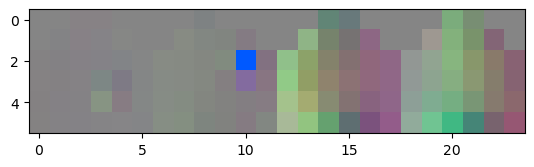

In [12]:
def get_fingertip_stacked_image(fingertip_values):
    curr_fingertip_values = torch.FloatTensor(fingertip_values)
    top_row = torch.concat([
        F.pad(curr_fingertip_values[finger_id, :2], (0,0,2,2)) 
        for finger_id in range(4)], dim=0).unsqueeze(0)

    sec_row = torch.concat([
        F.pad(curr_fingertip_values[finger_id, 2:6], (0,0,1,1))
        for finger_id in range(4)], dim=0).unsqueeze(0)

    tip_rest = torch.stack([
            torch.concat([
                curr_fingertip_values[finger_id, (6+6*row_id):(6+6*(row_id+1))]
                for finger_id in range(4)], dim=0)
        for row_id in range(4)], dim=0)

    fingertip_stacked = torch.concat([
        top_row, sec_row, tip_rest], dim=0)
    
    return fingertip_stacked

fingertip_stacked = get_fingertip_stacked_image(fingertip_values[ID])
plot_tactile_image(fingertip_stacked)

In [17]:
def get_fingertip_images(fingertip_values): # Instead of merging all of them will be giving them separately
    curr_fingertip_values = torch.FloatTensor(fingertip_values)
    
    # Concatenate the top row
    top_row = torch.stack([
        F.pad(curr_fingertip_values[finger_id, :2], (0,0,2,2)) 
        for finger_id in range(4)], dim=0).unsqueeze(1)
    
    sec_row = torch.stack([
        F.pad(curr_fingertip_values[finger_id, 2:6], (0,0,1,1))
        for finger_id in range(4)], dim=0).unsqueeze(1)
        
    tip_rest = torch.stack([
            torch.stack([
                curr_fingertip_values[finger_id, (6+6*row_id):(6+6*(row_id+1))]
                for finger_id in range(4)], dim=0)
        for row_id in range(4)], dim=0)
    
    fingertip_images = torch.concat(
        [top_row, sec_row, tip_rest], dim=1)
    
    # Returns (6, 24, 3) images
    return fingertip_images



In [21]:
def get_all_finger_images(finger_values, fingertip_values):

    curr_finger_values = torch.FloatTensor(finger_values).view(11,4,4,3)
    # Pad each of the finger readings to have similar readings as the tips
    curr_finger_values = F.pad(curr_finger_values, (0,0,1,1,1,1))

    # Add fingertips to these to have a final (15,6,6,3) reading
    fingertip_images = get_fingertip_images(fingertip_values)
    thumb_fingers = torch.concat([fingertip_images[0:1], curr_finger_values[:2]], dim=0)
    other_fingers = torch.concat([
        torch.concat([fingertip_images[i+1:i+2], curr_finger_values[2+(3*i):2+(3*(i+1))]], dim=0)
        for i in range(3)], dim=0)
    all_finger_images = torch.concat([thumb_fingers, other_fingers], dim=0)

    return all_finger_images


In [23]:
def get_whole_hand_images(palm_values, finger_values, fingertip_values):
    all_finger_images = get_all_finger_images(
        finger_values = finger_values, 
        fingertip_values = fingertip_values)
    
    # Pad this accordingly
    padded_finger_images = F.pad(all_finger_images, (0,0,0,0,0,0,1,0))
    
    all_fingers_image = torch.concat([
        torch.concat([padded_finger_images[i*4+j] for j in range(4)], dim=0)
        for i in range(4)
    ], dim=1)
    
    
    curr_palm_values = torch.FloatTensor(palm_values).view(3,4,6,3)
    top_rows = torch.concat(
        [F.pad(curr_palm_values[i,:], (0,0, 3,3, 1,1)) for i in range(2)],
        dim=1)
    bot_rows = F.pad(curr_palm_values[-1,:], (0,0, 15,3, 1,1))
    palm_image = torch.concat([top_rows, bot_rows], dim=0)

    whole_hand_image = torch.concat([all_fingers_image, palm_image], dim=0)
    
    
    
    return whole_hand_image

tensor(3104.5698) tensor(-950.4100) tensor(2154.1599)


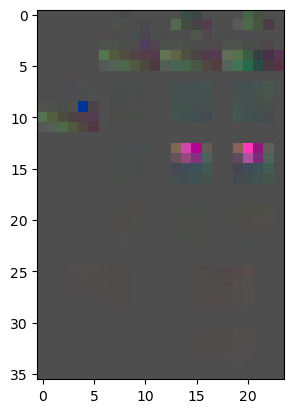

In [24]:
whole_hand_image = get_whole_hand_images(
        palm_values = palm_values[ID],
        finger_values = finger_values[ID],
        fingertip_values = fingertip_values[ID]
    )
plot_tactile_image(
    whole_hand_image
)

In [74]:
transform = T.Compose([
    T.Resize([224, 224]),
    T.Lambda(tactile_clamp_transform),
    T.Lambda(tactile_scale_transform)
])
permuted_hand_image = torch.permute(whole_hand_image, (2,0,1))
# print(whole_hand_image.shape)
transformed_img = transform(whole_hand_image)
# print(transformed_img.shape)
transformed_perm_img = transform(permuted_hand_image)
# print(transformed_perm_img.shape)


def plot_tactile_image_tensor(tactile_image):
    # Map it to 0 and 1 - not super certain this is correct
    min, max = tactile_image.min(), tactile_image.max()
    img_range = max - min
    img = (tactile_image - min) / img_range
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

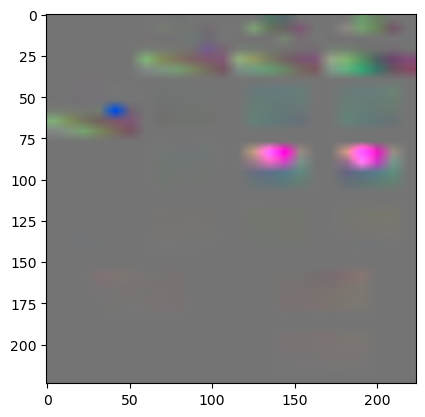

In [75]:
plot_tactile_image_tensor(transformed_perm_img)

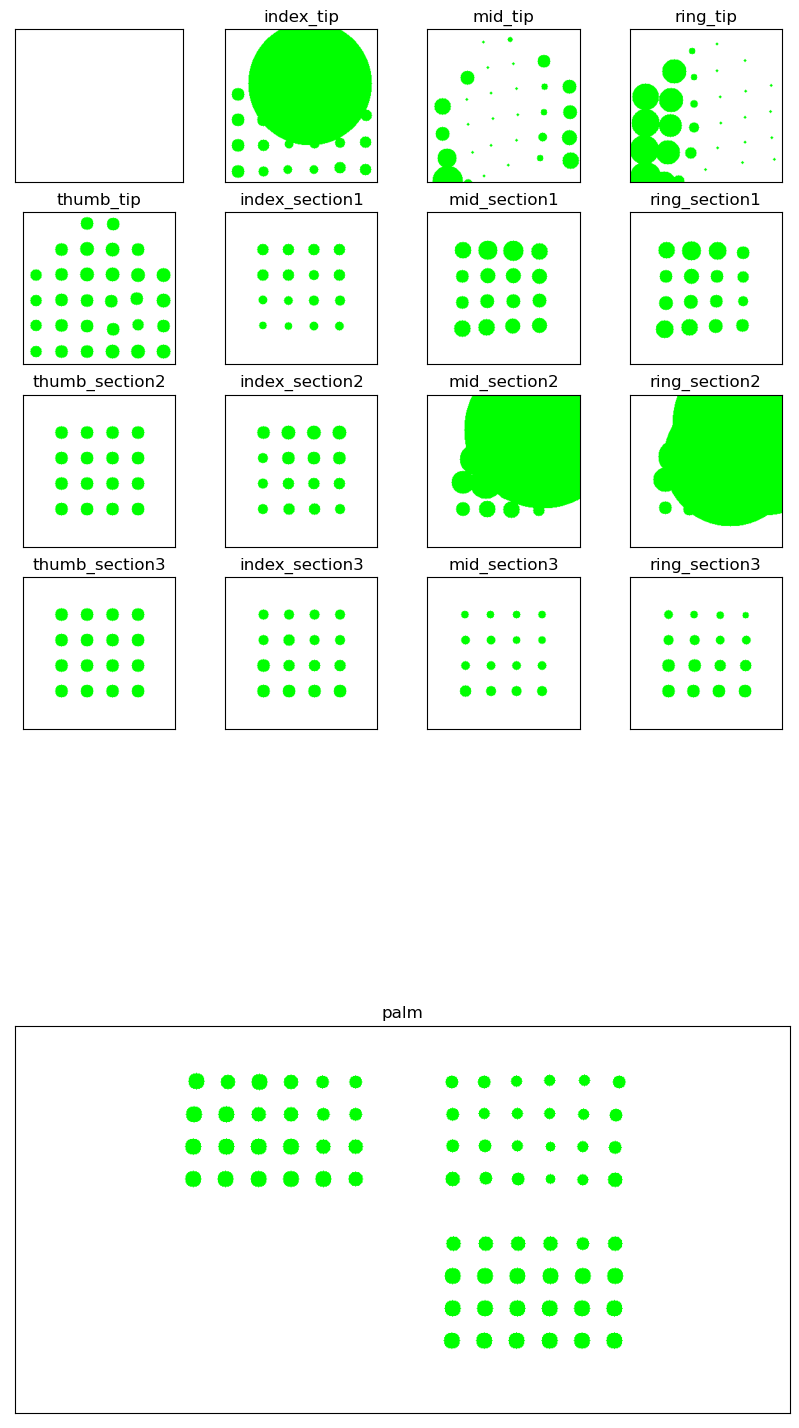

In [175]:
drawer = XelaCurvedPlotter() # This for debugging
drawer.visualize(palm_sensor_values=palm_values[ID], fingertip_sensor_values=fingertip_values[ID], finger_sensor_values=finger_values[ID])

In [36]:

from tactile_learning.tactile_data import TactileImage

class TactileImageCurved(TactileImage):
    def __init__(
        self,
        **kwargs
    ):
        super().__init__(**kwargs)

    def get(self, type, tactile_values):
        # tactile_values: dict(finger_values=(...), fingertip_values=(..), palm_values=(..))
        return self.get_whole_hand_tactile_image(
            finger_values = tactile_values['finger_values'],
            fingertip_values = tactile_values['fingertip_values'],
            palm_values = tactile_values['palm_values']
        ) # For now we don't have any other shuffle types

    
    def _get_fingertip_stacked_image(self, fingertip_values):
        curr_fingertip_values = torch.FloatTensor(fingertip_values)
        top_row = torch.concat([
            F.pad(curr_fingertip_values[finger_id, :2], (0,0,2,2)) 
            for finger_id in range(4)], dim=0).unsqueeze(0)

        sec_row = torch.concat([
            F.pad(curr_fingertip_values[finger_id, 2:6], (0,0,1,1))
            for finger_id in range(4)], dim=0).unsqueeze(0)

        tip_rest = torch.stack([
                torch.concat([
                    curr_fingertip_values[finger_id, (6+6*row_id):(6+6*(row_id+1))]
                    for finger_id in range(4)], dim=0)
            for row_id in range(4)], dim=0)

        fingertip_stacked = torch.concat([
            top_row, sec_row, tip_rest], dim=0)

        return fingertip_stacked
    
    def _get_fingertip_images(self, fingertip_values): # Instead of merging all of them will be giving them separately
        # fingertip_values: (4, 30, 3)
        curr_fingertip_values = torch.FloatTensor(fingertip_values)

        # Concatenate the top row
        top_row = torch.stack([
            F.pad(curr_fingertip_values[finger_id, :2], (0,0,2,2)) 
            for finger_id in range(4)], dim=0).unsqueeze(1)

        sec_row = torch.stack([
            F.pad(curr_fingertip_values[finger_id, 2:6], (0,0,1,1))
            for finger_id in range(4)], dim=0).unsqueeze(1)

        tip_rest = torch.stack([
                torch.stack([
                    curr_fingertip_values[finger_id, (6+6*row_id):(6+6*(row_id+1))]
                    for finger_id in range(4)], dim=0)
            for row_id in range(4)], dim=0)

        fingertip_images = torch.concat(
            [top_row, sec_row, tip_rest], dim=1)

        # Returns (6, 24, 3) images
        return fingertip_images


    def _get_all_finger_images(finger_values, fingertip_values):
        # fingertip_values: (4, 30, 3), finger_values: (11, 24, 3)
        curr_finger_values = torch.FloatTensor(finger_values).view(11,4,4,3)
        # Pad each of the finger section readings to have similar readings as the tips
        curr_finger_values = F.pad(curr_finger_values, (0,0,1,1,1,1))

        # Add fingertips to these to have a final (15,6,6,3) reading
        fingertip_images = get_fingertip_images(fingertip_values)
        thumb_fingers = torch.concat([fingertip_images[0:1], curr_finger_values[:2]], dim=0)
        other_fingers = torch.concat([
            torch.concat([fingertip_images[i+1:i+2], curr_finger_values[2+(3*i):2+(3*(i+1))]], dim=0)
            for i in range(3)], dim=0)
        all_finger_images = torch.concat([thumb_fingers, other_fingers], dim=0)

        return all_finger_images
    
    
    def get_whole_hand_tactile_image(self, palm_values, finger_values, fingertip_values):
        # palm_values: (3, 24, 3), fingertip_values: (4, 30, 3), finger_values: (11, 24, 3)
        
        # Get the (15,6,6,3) tactile images for all the finger segments including the tip
        all_finger_images = get_all_finger_images(
            finger_values = finger_values, 
            fingertip_values = fingertip_values)

        # Pad this accordingly as we used
        padded_finger_images = F.pad(all_finger_images, (0,0,0,0,0,0,1,0))

        # Merge all the fingers together
        all_fingers_image = torch.concat([
            torch.concat([padded_finger_images[i*4+j] for j in range(4)], dim=0)
            for i in range(4)
        ], dim=1)


        # Get the palm image - we pad them to fill out the emptiness of 
        curr_palm_values = torch.FloatTensor(palm_values).view(3,4,6,3)
        top_rows = torch.concat( # Top two palm pads 
            [F.pad(curr_palm_values[i,:], (0,0, 3,3, 1,1)) for i in range(2)],
            dim=1) 
        bot_rows = F.pad(curr_palm_values[-1,:], (0,0, 15,3, 1,1)) # Bottom palm pad
        palm_image = torch.concat([top_rows, bot_rows], dim=0)

        # Merge fingers images and palm together
        whole_hand_image = torch.concat([all_fingers_image, palm_image], dim=0)
        whole_hand_image = torch.permute(whole_hand_image, (2,0,1))
        return self.transform(whole_hand_image)
    
    def get_tactile_image_for_visualization(self, palm_values, finger_values, fingertip_values):
        tactile_image = self.get_whole_hand_tactile_image(palm_values, finger_values, fingertip_values)
        tactile_image = T.Resize(224)(tactile_image) # Don't need another normalization
        tactile_image = (tactile_image - tactile_image.min()) / (tactile_image.max() - tactile_image.min())
        npimg = tactile_image.numpy()
        return np.transpose(npimg, (1, 2, 0)) # When this is passed to plt.imshow() it should work


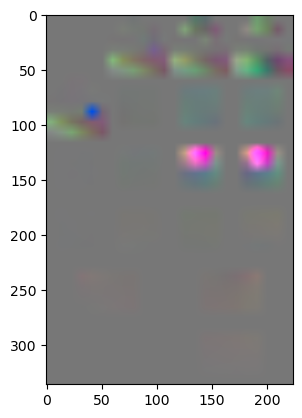

In [37]:
tactile_img = TactileImageCurved()
plt.imshow(
    tactile_img.get_tactile_image_for_visualization(
        palm_values = palm_values[ID],
        fingertip_values = fingertip_values[ID],
        finger_values = finger_values[ID])
)
plt.show()

In [ ]:
# Calculate the mean and stds of the images
def get_image_stats(len_image_dataset, image_loader):
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])

    # loop through images
    for inputs in tqdm(image_loader):
        psum    += inputs.sum(axis = [0, 2, 3])
        psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

    # pixel count
    count = len_image_dataset * 16 * 16

    # mean and std
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    # output
    print('mean: '  + str(total_mean))
    print('std:  '  + str(total_std))

    return total_mean, total_std


In [22]:
get_image_stats(len(dataset), dataloader)

100%|██████████| 2369/2369 [00:03<00:00, 772.17it/s]

mean: tensor([-6.5651,  3.4824, 10.0751])
std:  tensor([183.9877, 151.5086, 128.7941])


(tensor([-6.5651,  3.4824, 10.0751]), tensor([183.9877, 151.5086, 128.7941]))

In [53]:
# Method to load all the data from given roots and return arrays for it
def load_data(roots, demos_to_use=[], duration=120, representations=['image','tactile','allegro','kinova']): # If the total length is equal to 2 hrs - it means we want the whole data
    roots = sorted(roots)

    arm_indices = []
    arm_states = {}

    hand_indices = []
    hand_action_indices = []
    hand_tip_positions = {}
    hand_joint_positions = {}
    hand_joint_torques = {}
    hand_actions = {}

    tactile_indices = []
    tactile_values = {} 

    image_indices = []

    repr_types = []
    for demo_id, root in enumerate(roots):
        demo_num = int(root.split('/')[-1].split('_')[-1])
        print('demo_num: {}'.format(demo_num))
        if (len(demos_to_use) > 0 and demo_num in demos_to_use) or (len(demos_to_use) == 0):
            for repr_name in representations:
                repr_type = MODALITY_TYPES[repr_name]
                repr_types.append(repr_type)

                if repr_type == 'arm':
                    with open(os.path.join(root, f'{repr_name}_indices.pkl'), 'rb') as f:
                        curr_indices = pickle.load(f)
                        print('curr_indices lenght: {}'.format(len(curr_indices)))
                        arm_indices += curr_indices
                    with h5py.File(os.path.join(root, f'{repr_name}_cartesian_states.h5'), 'r') as f:
                        state = np.concatenate([f['positions'][()], f['orientations'][()]], axis=1)     
                        arm_states[demo_id] = state
                    print('arm_indices {} in {}'.format(curr_indices, repr_name))

                if repr_type == 'hand':
                    with open(os.path.join(root, f'{repr_name}_indices.pkl'), 'rb') as f:
                        hand_indices += pickle.load(f)
                    with open(os.path.join(root, f'{repr_name}_action_indices.pkl'), 'rb') as f:
                        hand_action_indices += pickle.load(f)
                    with h5py.File(os.path.join(root, f'{repr_name}_fingertip_states.h5'), 'r') as f:
                        hand_tip_positions[demo_id] = f['positions'][()]
                    with h5py.File(os.path.join(root, f'{repr_name}_joint_states.h5'), 'r') as f:
                        hand_joint_positions[demo_id] = f['positions'][()]
                        hand_joint_torques[demo_id] = f['efforts'][()]
                    with h5py.File(os.path.join(root, f'{repr_name}_commanded_joint_states.h5'), 'r') as f:
                        hand_actions[demo_id] = f['positions'][()] # Positions are to be learned - since this is a position control
                
                if repr_type == 'tactile':
                    with open(os.path.join(root, 'tactile_indices.pkl'), 'rb') as f:
                        tactile_indices += pickle.load(f)
                    with h5py.File(os.path.join(root, 'touch_sensor_values.h5'), 'r') as f:
                        if 'sensor_values' in f.keys(): # It means it is flat fingered sensors
                            tactile_values[demo_id] = f['sensor_values'][()]
                        else:
                            if 'finger_sensor_values' in f.keys() and 'fingertip_sensor_values' in f.keys() and 'palm_sensor_values' in f.keys():
                                tactile_values[demo_id] = dict(
                                    finger_values = f['finger_sensor_values'][()],
                                    fingertip_values = f['fingertip_sensor_values'][()],
                                    palm_values = f['palm_sensor_values'][()]
                                )

                if repr_type == 'image':
                    with open(os.path.join(root, 'image_indices.pkl'), 'rb') as f:
                        image_indices += pickle.load(f)

    print('REPR TYPES IN LOAD_DATA: {}'.format(
        repr_types
    ))

    # Find the total lengths now
    # whole_length = len(tactile_indices)
    whole_length = max([len(data_idx) for data_idx in [tactile_indices, hand_indices, arm_indices, image_indices]])
    desired_len = int((duration / 120) * whole_length)

    data = dict()
    # for repr_type in repr_types:
    if 'hand' in repr_types:
        data['hand_joint_states'] = dict(
            indices = hand_indices[:desired_len],
            values = hand_joint_positions,
            torques = hand_joint_torques
        )
        data['hand_tip_states'] = dict(
            indices = hand_indices[:desired_len],
            values = hand_tip_positions
        )
        data['hand_actions'] = dict(
            indices = hand_action_indices[:desired_len],
            values = hand_actions
        )
    if 'arm' in repr_types:
        data['arm'] = dict(
            indices = arm_indices[:desired_len], 
            values = arm_states
        )

    if 'tactile' in repr_types:
        data['tactile'] = dict(
            indices = tactile_indices[:desired_len],
            values = tactile_values # This will be an array of dictionaries if the tactile is curved
        )

    if 'image' in repr_types:
        data['image'] = dict(
            indices = image_indices[:desired_len]
        )

    return data 

In [54]:
roots = [root]

In [55]:
from tactile_learning.utils import MODALITY_TYPES
data = load_data(
    roots = roots,
    representations = ['image', 'allegro', 'franka', 'tactile'])


demo_num: 1
curr_indices lenght: 192
arm_indices [[0, 67], [0, 102], [0, 108], [0, 112], [0, 126], [0, 144], [0, 150], [0, 177], [0, 203], [0, 219], [0, 238], [0, 256], [0, 274], [0, 292], [0, 305], [0, 322], [0, 338], [0, 370], [0, 389], [0, 409], [0, 429], [0, 464], [0, 567], [0, 601], [0, 620], [0, 627], [0, 633], [0, 650], [0, 668], [0, 675], [0, 702], [0, 723], [0, 726], [0, 746], [0, 795], [0, 800], [0, 819], [0, 834], [0, 843], [0, 855], [0, 864], [0, 888], [0, 897], [0, 915], [0, 936], [0, 943], [0, 961], [0, 979], [0, 988], [0, 1002], [0, 1007], [0, 1010], [0, 1013], [0, 1015], [0, 1018], [0, 1021], [0, 1023], [0, 1025], [0, 1027], [0, 1029], [0, 1032], [0, 1034], [0, 1037], [0, 1039], [0, 1041], [0, 1045], [0, 1052], [0, 1065], [0, 1071], [0, 1076], [0, 1084], [0, 1090], [0, 1093], [0, 1102], [0, 1109], [0, 1123], [0, 1129], [0, 1135], [0, 1146], [0, 1150], [0, 1154], [0, 1157], [0, 1160], [0, 1167], [0, 1179], [0, 1188], [0, 1192], [0, 1225], [0, 1250], [0, 1295], [0, 1340],

In [62]:
demo_id, tactile_id = data['tactile']['indices'][100] # Getting the 200th dataset
tactile_values = dict(
    fingertip_values = data['tactile']['values'][demo_id]['fingertip_values'][tactile_id],
    finger_values = data['tactile']['values'][demo_id]['finger_values'][tactile_id],
    palm_values = data['tactile']['values'][demo_id]['palm_values'][tactile_id],
)
tactile_img = TactileImageCurved()
tactile_image = tactile_img.get(type=None, tactile_values=tactile_values)

In [71]:
# Implement the dataset for these curved images
from torch.utils import data
class TactileCurvedSSlDataset(data.Dataset):
    # Dataset for all possible tactile types (stacked, whole hand, one sensor)
    def __init__(
        self,
        data_path,
        tactile_img_size=(224,224),
        duration=120, # Duration in minutes - the max is 120 minutes (it is considered max) - from now on the play 
        shuffle_type=None, # Can either be pad, whole or None
        **kwargs
    ):
        super().__init__()
        self.roots = glob.glob(f'{data_path}/demonstration_*')
        self.roots = sorted(self.roots)
        self.data = load_data(self.roots, demos_to_use=[], duration=duration, representations=['tactile'])
        
        # Set the transforms accordingly
        self.tactile_img = TactileImageCurved(
            tactile_image_size = tactile_img_size,
            shuffle_type = shuffle_type
        )
            
    def __len__(self):
        return len(self.data['tactile']['indices'])
        
    def _get_proper_tactile_value(self, index):
        # This method will return index to tactile_value as a dictionary
        demo_id, tactile_id = self.data['tactile']['indices'][index] # Getting the 200th dataset
        tactile_value = dict(
            fingertip_values = self.data['tactile']['values'][demo_id]['fingertip_values'][tactile_id],
            finger_values = self.data['tactile']['values'][demo_id]['finger_values'][tactile_id],
            palm_values = self.data['tactile']['values'][demo_id]['palm_values'][tactile_id],
        )
        return tactile_value

    def _get_tactile_image(self, tactile_values):
        return self.tactile_img.get(
            type = None,
            tactile_values = tactile_values
        )

    def __getitem__(self, index):
        tactile_value = self._get_proper_tactile_value(index)
        tactile_image = self._get_tactile_image(tactile_value)
        
        return tactile_image
        


In [72]:
dataset = TactileCurvedSSlDataset(data_path='/data/sr_test',  tactile_img_size=(224,224))
train_dset_size = int(len(dataset) * 0.8)
test_dset_size = len(dataset) - train_dset_size
# Random split the train and validation datasets
train_dset, test_dset = data.random_split(dataset, 
                                         [train_dset_size, test_dset_size],
                                         generator=torch.Generator().manual_seed(0))
train_sampler = None
test_sampler = None # val will not be shuffled

batch_size = 32
train_loader = data.DataLoader(train_dset, batch_size=batch_size, shuffle=train_sampler is None,
                                num_workers=4, sampler=train_sampler)
test_loader = data.DataLoader(test_dset, batch_size=batch_size, shuffle=test_sampler is None,
                                num_workers=4, sampler=test_sampler)



demo_num: 1
REPR TYPES IN LOAD_DATA: ['tactile']


In [73]:
for batch in train_loader:
    print(batch.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([25, 3, 224, 224])
